# Model predictive control (MPC)
Model predictive control (MPC) is an advanced method of process control, the main advantage of MPC is the fact that it allows the current timeslot to be optimized, while keeping future timeslots in account. This is achieved by optimizing a finite time-horizon, but only implementing the current timeslot and then optimizing again, repeatedly, thus differing from LQR. Also MPC has the ability to anticipate future events and can take control actions accordingly.

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [266]:
# Import environment
from environments.cartPendulum import cartPendulum

env = cartPendulum(mass_cart=1, mass_pendulum=0.1, length_pendulum=1, gravity=9.81)
env.step_size = 0.02

## Developing the model
MPC is a model based control approach which means we need to know the model of the system in order to use it. The equations of motion for the cart pendulum system is given as follows:
$$
    \underbrace{
    \begin{bmatrix}
        1 & 0 & 0 & 0\\
        0 & 1 & 0 & 0\\
        0 & 0 & m_{c} + m_{p} & l m_{p} \cos (\theta)\\
        0 & 0 & \cos (\theta) & l
    \end{bmatrix}
    }_{\boldsymbol{M}}
    \underbrace{
    \begin{bmatrix}
        \dot{x}\\
        \dot{\theta}\\
        \ddot{x}\\
        \ddot{\theta}
    \end{bmatrix}
    }_{\boldsymbol{x}}
    =
    \underbrace{
    \begin{bmatrix}
        \dot{x}\\
        \dot{\theta}\\
        l m_{p} \dot{\theta}^{2} \sin (\theta) + u\\
        g \sin (\theta)
    \end{bmatrix}
    }_{\boldsymbol{F}}
$$

In order to make this more general we will use sympy to do the calculations symbolically

In [100]:
import sympy as sp
sp.init_printing()

# Create the symbolic variabels that we will use
m_c, m_p, l, theta, x, theta_dot, x_dot, u, g = sp.symbols('m_c m_p l theta x theta_dot x_dot u g')

# Compute mass and forcing matrix as given above
mass_matrix = sp.Matrix([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, m_c + m_p, m_p*l*sp.cos(theta)],[0, 0, sp.cos(theta), l]])
forcing_matrix = sp.Matrix([[x_dot], [theta_dot], [m_p*l*theta_dot*theta_dot*sp.sin(theta) + u], [g*sp.sin(theta)]])

We first put the system on the form:
$$
    \dot{\boldsymbol{x}} = f(\boldsymbol{x}, \boldsymbol{u}) = \boldsymbol{M}^{-1}\boldsymbol{F}
$$
We then linearize the system by compute the matrix $\boldsymbol{A}$ and $\boldsymbol{B}$ according to: 

$$
\boldsymbol{A} 
=
\frac{\partial f}{\partial \boldsymbol{x}}  \bigg|_{\boldsymbol{x} = 0}
=
\begin{bmatrix}
    \frac{\partial f_1}{\partial x_1}  & \cdots & \frac{\partial f_1}{\partial x_n}  \\
    \vdots          &        & \vdots          \\
    \frac{\partial f_n}{\partial x_1}  & \cdots & \frac{\partial f_n}{\partial x_n} 
\end{bmatrix}\Bigg|_{\boldsymbol{x} = 0}
$$

$$
\boldsymbol{B} 
=
\frac{\partial f}{\partial \boldsymbol{x}}  \bigg|_{\boldsymbol{x} = 0}
=
\begin{bmatrix}
    \frac{\partial f_1}{\partial u} \\
    \vdots \\
    \frac{\partial f_n}{\partial u}
\end{bmatrix}\Bigg|_{\boldsymbol{x} = 0}
$$
This gives us an approximationogf the system aboute the upright equilibrium:
$$
\dot{\boldsymbol{x}} = \boldsymbol{A} \boldsymbol{x} + \boldsymbol{B} u
$$

In [101]:
# find f(x) as specified above
f = mass_matrix.inv()@forcing_matrix

# Compute the jacobain of the system
J = sp.Matrix([sp.diff(f, x).T, sp.diff(f, theta).T, sp.diff(f, x_dot).T, sp.diff(f, theta_dot).T]).T

# Compute A and B
A = sp.simplify(J.subs({x: 0, theta: 0 , x_dot : 0, theta_dot : 0}))
B = sp.simplify(sp.diff(f, u).subs({x: 0, theta: 0 , x_dot : 0, theta_dot : 0}))

A, B

⎛⎡0       0        1  0⎤, ⎡  0  ⎤⎞
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢0       0        0  1⎥  ⎢  0  ⎥⎟
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢      -g⋅mₚ          ⎥  ⎢  1  ⎥⎟
⎜⎢0     ──────     0  0⎥  ⎢ ─── ⎥⎟
⎜⎢       m_c           ⎥  ⎢ m_c ⎥⎟
⎜⎢                     ⎥  ⎢     ⎥⎟
⎜⎢   g⋅(m_c + mₚ)      ⎥  ⎢ -1  ⎥⎟
⎜⎢0  ────────────  0  0⎥  ⎢─────⎥⎟
⎝⎣      l⋅m_c          ⎦  ⎣l⋅m_c⎦⎠

## Model predictve controll
The Quadratic and linear cost MPC can be written as the following opptimization problem:
$$
    \begin{aligned}
        \min & \quad \frac{1}{2} \boldsymbol{z}^{\top} \boldsymbol{G} \boldsymbol{z} + \boldsymbol{c}^{\top} \boldsymbol{z}\\
        s.t. & \quad \boldsymbol{A}_{eq} \boldsymbol{z} = \boldsymbol{b}_{eq} \\
             & \quad \boldsymbol{A}_{ieq} \boldsymbol{z} \leq \boldsymbol{b}_{ieq} \\
    \end{aligned}
$$
Where $\boldsymbol{G}$ is the quadratic cost function, $\boldsymbol{c}$ is the linear cost, $\boldsymbol{A}_{eq}$ and $\boldsymbol{b}_{eq}$ represent the linear equality constraints, and $\boldsymbol{A}_{ieq}$ and $\boldsymbol{b}_{ieq}$ represents the linear inequality constraints. The following functions build the equality constraints, given by the model, and the 

In [102]:
import numpy as np

# Generates G matrix given quadratic penaly Q and R
def gen_g(q, r, n):
    nx = np.shape(q)[0]
    nu = np.shape(r)[0]
    upper = np.concatenate((np.kron(np.identity(n), q), np.zeros([nx * n, nu * n])), axis=1)
    lower = np.concatenate((np.zeros([nu * n, nx * n]), np.kron(np.identity(n), r)), axis=1)
    return np.concatenate((upper, lower), axis=0)

# Generates the Aeq matrix given discrete model Ad, Bd
def gen_a(a, b, n):
    nx = np.shape(a)[0]
    a_eq = np.concatenate((np.zeros([nx, nx * (n - 1)]), np.kron(np.identity(n - 1), -a)), axis=0)
    a_eq = np.concatenate((a_eq, np.zeros([nx * n, nx])), axis=1)
    a_eq = np.add(a_eq, np.identity(nx * n))
    a_eq = np.concatenate((a_eq, np.kron(np.identity(n), -b)), axis=1)
    return a_eq

# Generates the b vector, given the initial condition x0 and the discrete model matrix Ad
def gen_b(a, x0, n):
    nx = np.shape(a)[0]
    return np.asarray(np.concatenate((np.matmul(a, x0), np.zeros([nx * (n - 1), 1])), axis=0)).ravel()


In [322]:
import scipy.signal
parameters = {m_c: env.m_c, m_p: env.m_p, l: env.l, g: env.g}

# Weight matrix Q and R
Q = np.matrix([[1, 0, 0, 0], [0, 20, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
R = np.matrix([[1]])

# Evaluate the numerical value of the continuouse A and B matrices
A_c = np.matrix(A.subs(parameters)).astype(np.float64)
B_c = np.matrix(B.subs(parameters)).astype(np.float64)

# Compute the discrete A and B matrices
A_d, B_d, _, _, _ = scipy.signal.cont2discrete((A_c, B_c, _, _), dt=env.step_size*10)

# Define prediction horizon
N = 25

# Define initial conditions
x0 = np.array([env.x]).T

# Compute the optimization problem matrices
Aeq = gen_a(A_d, B_d, N)
Beq = gen_b(A_d, x0, N)
G = gen_g(Q, R, N)

# Define objectve functions and constraint functions
fun = lambda x: (x.T@G@x)[0,0]
g_1 = lambda x: 5 - np.abs(x[4*N::1])
h_1 = lambda x: Aeq@x - Beq

# Define helper functions
jac = lambda x: np.array(G@x)

x0 = np.zeros((4*N + 1*N, 1))

In [337]:
import scipy.optimize
def MPC(x0):
    res = scipy.optimize.minimize(fun = fun, 
                                  x0 = x0,
                                  method='SLSQP',
                                  jac = jac,
                                  constraints=({'type':'eq', 'fun':h_1}, {'type': 'ineq', 'fun': g_1}))
    u = res.x[4*N]
    return res.x ,u

In [338]:
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
from IPython.display import HTML

# Simulate the environment for n_steps and save states in X
n_steps = 500
X = np.zeros((len(env.x), n_steps))
theta = (2*np.random.random() - 1)*0.4
state = env.init([0, 0.4, 0, 0])
U = np.zeros((n_steps))
x = x0
for step in range(n_steps):
    X[:, step] = env.x
    Beq = gen_b(A_d,np.array([env.x]).T, N)
    if step%10 == 0:
        x, u = MPC(x)
    U[step] = u
    state = env.step(u)

# Create the figure
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-1.1, 1.1), aspect='equal')
line, = ax.plot([], [], lw=2, marker='o', markersize=6)
rect = Rectangle([X[0][0] - 0.2, -0.1],0.4, 0.2, fill=True, color='red', ec='black')
ax.add_patch(rect)

animate = lambda i: (rect.set_xy([X[0,i] - 0.2, -0.1]), 
                     line.set_data([X[0,i], X[0,i] + np.sin(X[1, i])],[0, np.cos(X[1, i])]))

# Create and display animation
plt.close()
anim = animation.FuncAnimation(fig, animate, interval = env.step_size*1000, frames = n_steps)
HTML(anim.to_html5_video())

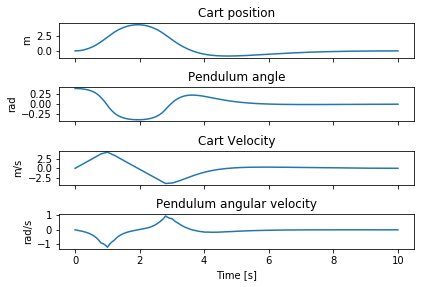

In [339]:
# Plot trajectory
#%matplotlib auto
t = np.linspace(0, n_steps*env.step_size, X.shape[1])
names = ["Cart position", "Pendulum angle", "Cart Velocity", "Pendulum angular velocity"]
units = ["m", "rad", "m/s", "rad/s"]
fig, axarr = plt.subplots(4, sharex=True)
for i in range(4):
    axarr[i].plot(t, X.T[:, i])
    axarr[i].title.set_text(names[i])
    axarr[i].set_ylabel(units[i])

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.xlabel('Time [s]')
plt.show()

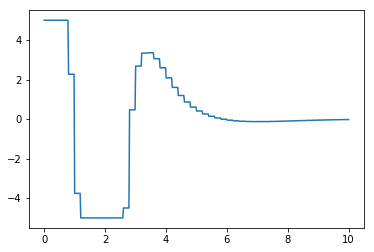

In [340]:
# Plot input
t = np.linspace(0, n_steps*env.step_size, X.shape[1])
plt.plot(t, U)
plt.show()